# Predicting bicycle traffic by linear regression

An Example of Linear Regression using hourly bike traffic data.

 This Notebook extends work done in a University module from the University of Exeter (MTHM503 Applications of Data Science and Statistics) taught by Stefan Siegert (S.Siegert@exeter.ac.uk). The analysis itself in this notebook is inspired by the analysis in chapter 5.6 in the Python Data Science Handbook. (https://www.oreilly.com/library/view/python-data-science/9781491912126/)

## Loading Packages and Data

We are loading the various options, packages, and data here.

In [1]:
## Display multiple outputs from each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
bike = pd.read_csv('data/FremontBridge.csv', 
                   index_col='Date', parse_dates=False)
bike.head(4)
bike.index = pd.to_datetime(bike.index, format="%m/%d/%Y %I:%M:%S %p")
bike.head(4)

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
10/03/2012 12:00:00 AM,13.0,4.0,9.0
10/03/2012 01:00:00 AM,10.0,4.0,6.0
10/03/2012 02:00:00 AM,2.0,1.0,1.0
10/03/2012 03:00:00 AM,5.0,2.0,3.0


,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0


In [3]:
## Format code

# we are telling to pandas that the origional date format was
#%m months (amercians put month first for some reason)
#%d days
#%Y years
#%I 12 hour based hour
#%M Mins
#%S Seconds
#%p AM/PM

## Need to specify the full format string as pandas throws an error if this was the code
# bike.index = pd.to_datetime(bike.index, format="%m/%d/%Y")

## Data pre-processing

The bicycle traffic data has hourly counts. For the time being, we will only be interested in daily counts, so we have to aggregate the counts to daily data. We first create a new column date_day where we format the index from hourly to format YYYY-MM-DD using strftime. Then we use the groupby-agg approach to sum up the hourly counts to daily counts. We finally rename the column and the index variable to something more descriptive.

In [5]:
## Using String from time method as useful way to knock off time and am/pm data
bike['date_day'] = bike.index.strftime('%Y-%m-%d')



bike_daily = bike.groupby('date_day').sum()
bike_daily.rename( columns = {"Fremont Bridge Total":"total_bikes",
                             "Fremont Bridge East Sidewalk":"east_bikes",
                             "Fremont Bridge West Sidewalk":"west_bikes"}, inplace = True)
bike_daily.index = pd.to_datetime(bike_daily.index)
bike_daily.head(10)

,total_bikes,east_bikes,west_bikes
date_day,,,
2012-10-03,7042.0,3520.0,3522.0
2012-10-04,6950.0,3416.0,3534.0
2012-10-05,6296.0,3116.0,3180.0
2012-10-06,4012.0,2160.0,1852.0
2012-10-07,4284.0,2382.0,1902.0
2012-10-08,7074.0,3658.0,3416.0
2012-10-09,7002.0,3518.0,3484.0
2012-10-10,6470.0,3296.0,3174.0
2012-10-11,6094.0,3158.0,2936.0


We now have a date table and total bike column

Alwys good to check if there are any NA values


In [6]:
bike_daily.isnull().sum()

total_bikes    0
east_bikes     0
west_bikes     0
dtype: int64

In [7]:
bike_daily.index.dtype

dtype('<M8[ns]')

## Exploratory data analysis

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Daily bicycle counts over Fremont Bridge, Seattle')

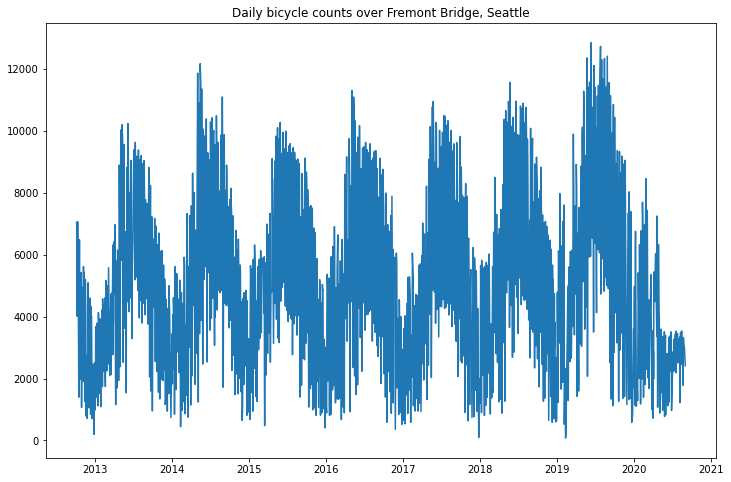

In [8]:
## Plotting the Total daily count of bikes

plt.figure(figsize = [12,8])
plt.style.use("fast")
plt.plot_date(bike_daily.index, bike_daily["total_bikes"], '-')
plt.title('Daily bicycle counts over Fremont Bridge, Seattle')
plt.show()

**Observations**

- There is a clear seasonal pattern in bicycle counts in Seattle, ranging from up to 12000 per day in summer to almost zero in winter.
- There is also some indication of an upward trend in bicycle counts, that is a gradual increase over time, at least in the annual maximum.
- The year 2020 is clearly different from the other years, most likely due to the covid-19 lockdown and due to civil unrest in Seattle during this time.

**Possible research questions**

- How much of the 2012-2019 bicycle traffic can be explained by a simple sinusoidal pattern, without regard for weather effects?
- Is there a long term growth coefficient?
- Is there a weekend effect?
- How much does the model prediction for 2020 differ from the actually observed bicycle counts? (This difference can allow us to analyse the effect of Seattle's covid-19 lockdown and civil unrest during this period.)

## Fitting a seasonal model

We start by assuming that the bicycle counts $y_1, \dots, y_n$ can be modelled as an annual sinusoidal oscillation around a constant mean level

$$y_t = \beta_0 + A\sin(\omega t + \phi) + \epsilon_t$$

The constant $A$ is the amplitude of the oscillation, the constant $\omega$ is the frequency, and $\phi$ is the phase shift. Since we assume an annual oscillation, we can set $\omega = 2\pi/365.25$. The parameters $A$ and $\phi$ are unknown and have to be estimated. 

In this form the model for $y$ cannot be fitted by simple linear regression, because one of the unknown parameters $\phi$ appears inside a nonlinear function ($\sin$).  But we can use the trigonometric equality $\sin(x + y) = \sin(x)\cos(y) + \cos(x)\sin(y)$ so we have $A\sin(\omega t + \phi) = A\sin(\omega t)\cos(\phi) + A\cos(\omega t)\sin(\phi)$. We can rewrite the seasonal model for $y_t$ as

$$y_t = \beta_0 + \beta_1 \sin[2\pi / (365.25) t] + \beta_2 \cos[2\pi / (365.25) t] + \epsilon_t$$

where the unknown parameters $\beta_1$ and $\beta_2$ are related to the amplitude $A$ and phase factor $\phi$. By defining the covariates 

$$x_{1,t} = \sin[2\pi/(365.25) t]$$

and

$$x_{2,t} = \cos[2\pi/(365.25) t]$$

we can write

$$y_t = \beta_0 + \beta_1 x_{1,t} + \beta_2 x_{2,t} + \epsilon_t$$

To answer the questions lets us take the data below <= 2019 so the covid effect isnt taken into account and then we can see the difference between the predicted and the actual values. 

In [14]:
## Using the .index function to filter on the index instead of filtering on the values. 
bike_daily_norm = bike_daily[bike_daily.index.year <= 2019]

In [23]:
## defining the components need for the linear regression. 
n = len( bike_daily_norm ) # number of days
t = np.arange(n) # np array of day numbers [1,2,3.....n]
omega = 2 * np.pi / 365.25

# horizontal stacking column vectors, to be fed into the lin alg function. 
X_seasonal = np.stack([np.sin(omega * t), np.cos(omega * t)], axis=1)
X_seasonal[0:10]

array([[0.        , 1.        ],
       [0.01720158, 0.99985204],
       [0.03439806, 0.99940821],
       [0.05158437, 0.99866864],
       [0.06875541, 0.99763355],
       [0.0859061 , 0.99630324],
       [0.10303138, 0.99467811],
       [0.12012617, 0.99275863],
       [0.1371854 , 0.99054539],
       [0.15420405, 0.98803902]])

In [27]:
## Defining the data
y = bike_daily_norm['total_bikes']

In [28]:
## from from sklearn.linear_model import LinearRegression

## Declaring the lm() model
lm = LinearRegression()

In [29]:
lm_seasonal = lm.fit(X_seasonal, y)
lm_seasonal.intercept_
lm_seasonal.coef_

5531.201955838146

array([-2377.53511058,   227.07393563])

Intercept is 5530 bike. Beta1 is -2377 and Beta2 is 227

Now we need to fit the data predicted from the linear model and plot against the known data.

<Figure size 864x576 with 0 Axes>

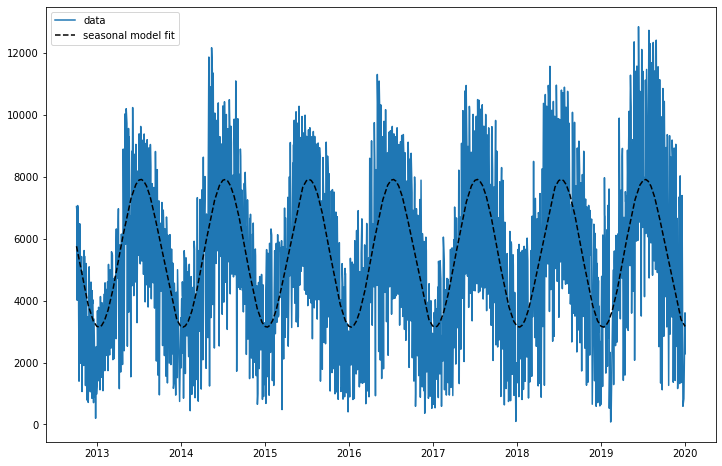

In [32]:
y_seasonal = pd.Series(data= lm_seasonal.predict(X_seasonal), index=y.index)

plt.figure(figsize = [12,8])
plt.style.use("fast")
plt.plot(y, label='data')
plt.plot(y_seasonal, '--k', label='seasonal model fit')
plt.legend()
plt.show()

The fitted model produced a seasonally varying function that roughly matches the amplitude and phase of the count data.

To quantify how much of the variability of the data is explained by the seasonal model fit, we compare the variance of the data to the variance of the residuals of the seasonal fit. The smaller the variance of the residuals is compared to the total variance, the more explanatory power our model has.

In [35]:
## Remember the data was truncated to the end of 2019 to avoid the covid factor.
total_var = np.var(y.values) # of the data
resid_var_seas = np.var(y.values - y_seasonal.values) # of the data - predicted model

The coefficient of determination  **𝑅2**  is given by one minus the ratio of residual variance to total variance. If the residual variance equals total variance, the model does not explain anything and  **𝑅2=0** . If the residual variance is 0, the model fits the data perfectly, and  **𝑅2=1** . **So**  𝑅2  measures model fit on a scale from zero to one.

In [36]:
R2_seas = 1 - resid_var_seas / total_var
R2_seas

0.3778130484014063

## Including a linear trend and Weekend factor

The next model we fit adds a linear function of time to the seasonal pattern and the weekend factor. The mathematical form is as follows

$$y_t = \beta_0 + \beta_1 \sin(\omega t) + \beta_2 \cos(\omega t) + \beta_3 t + \beta_4 I(x_w) + \epsilon_t$$

We can interpret the parameter $\beta_3$ as the average additional number of cyclists per day and $\beta_4$ as the additional number of cyclists due to the weekend effect.

First we need to calculate which day is the weekend and which is weekday. We use the dayofweek function from padas module. 

In [57]:
y

date_day
2012-10-03    7042.0
2012-10-04    6950.0
2012-10-05    6296.0
2012-10-06    4012.0
2012-10-07    4284.0
               ...  
2019-12-27    2276.0
2019-12-28    1676.0
2019-12-29    1846.0
2019-12-30    3606.0
2019-12-31    2284.0
Name: total_bikes, Length: 2646, dtype: float64

In [58]:
bike_daily_norm["day_of_week"] = bike_daily_norm.index.dayofweek
# bike_daily_norm["day_of_week"] = datetime.datetime.weekday(bike_daily_norm.index)

<ipython-input-58-06d394e575b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_daily_norm["day_of_week"] = bike_daily_norm.index.dayofweek


In [65]:
bike_daily_norm["is_weekend"] = 0
## The day of the week with Monday=0, Sunday=6.

## monday 0 to friday 4
bike_daily_norm.loc[ bike_daily_norm["day_of_week"].isin([range(0,5)] ), "is_weekend"] = 0
## sat = 5 and sun = 6
bike_daily_norm.loc[ bike_daily_norm["day_of_week"].isin([5,6] ), "is_weekend"] = 1

In [66]:
## checking
2/7
ratio = bike_daily_norm["is_weekend"].value_counts()
ratio
ratio[1]/(ratio.sum())

0.2857142857142857

0    1890
1     756
Name: is_weekend, dtype: int64

0.2857142857142857

These two statements are essentially equal so we have succesfully added is weekend. lets check with specific dates.

In [71]:
## Friday 4th Jan 2019
bike_daily_norm.loc["2019-01-04", "day_of_week"]
bike_daily_norm.loc["2019-01-04", "is_weekend"]

# Sat 5th Jan 2019
bike_daily_norm.loc["2019-01-05", "day_of_week"]
bike_daily_norm.loc["2019-01-05", "is_weekend"]

# Mon 7th Jan 2019
bike_daily_norm.loc["2019-01-07", "day_of_week"]
bike_daily_norm.loc["2019-01-07", "is_weekend"]

4.0

0.0

5.0

1.0

0.0

0.0

Works as anticipated

## Defining our 2nd Model

In [79]:
weekend = bike_daily_norm["is_weekend"]
weekend = weekend.to_numpy()

In [85]:
X_mod2 = np.hstack([np.sin(omega * t).reshape(n, 1), np.cos(omega * t).reshape(n, 1), np.arange(n).reshape(n, 1), weekend.reshape(n, 1) ])

In [86]:
X_mod2[0:20]

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.72015754e-02, 9.99852042e-01, 1.00000000e+00, 0.00000000e+00],
       [3.43980606e-02, 9.99408212e-01, 2.00000000e+00, 0.00000000e+00],
       [5.15843669e-02, 9.98668640e-01, 3.00000000e+00, 1.00000000e+00],
       [6.87554085e-02, 9.97633547e-01, 4.00000000e+00, 1.00000000e+00],
       [8.59061043e-02, 9.96303238e-01, 5.00000000e+00, 0.00000000e+00],
       [1.03031379e-01, 9.94678106e-01, 6.00000000e+00, 0.00000000e+00],
       [1.20126165e-01, 9.92758634e-01, 7.00000000e+00, 0.00000000e+00],
       [1.37185404e-01, 9.90545388e-01, 8.00000000e+00, 0.00000000e+00],
       [1.54204048e-01, 9.88039023e-01, 9.00000000e+00, 0.00000000e+00],
       [1.71177060e-01, 9.85240283e-01, 1.00000000e+01, 1.00000000e+00],
       [1.88099418e-01, 9.82149993e-01, 1.10000000e+01, 1.00000000e+00],
       [2.04966114e-01, 9.78769070e-01, 1.20000000e+01, 0.00000000e+00],
       [2.21772158e-01, 9.75098513e-01, 1.30000000e

we can see that seasonal components oscillating, we have the long term linear trend increasing day be day and a weekend indicator function

In [88]:
## 

<Figure size 864x576 with 0 Axes>

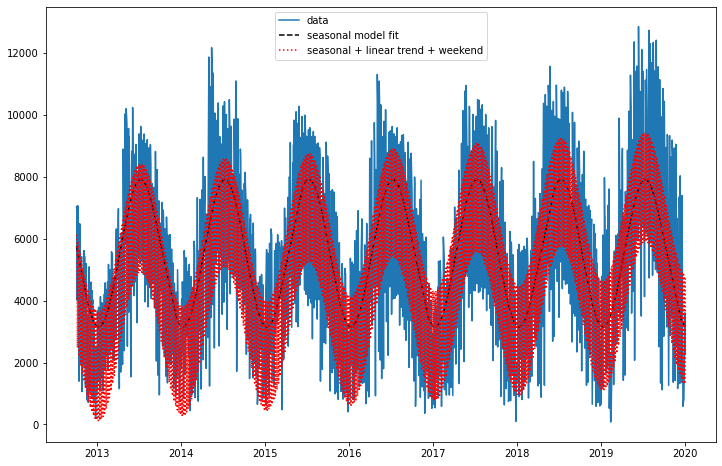

In [91]:
## run the model
lm_mod2 = lm.fit(X_mod2, y)

## calc new fitted values
y_mod2 = pd.Series(data=lm_mod2.predict(X_mod2), index=y.index)

## and plot

plt.figure(figsize = [12,8])
plt.style.use("fast")
plt.plot(y, label='data')
plt.plot(y_seasonal, '--k', label='seasonal model fit')
plt.plot(y_mod2, ':r', label='seasonal + linear trend + weekend')
plt.legend()
plt.show()

Its unclear whether there is a long term trend but the thickness of the red curve suggests the weekend indicator factor is a sizeable one

In [92]:
lm_mod2.intercept_
lm_mod2.coef_

## Remember the data was truncated to the end of 2019 to avoid the covid factor.
total_var = np.var(y.values) # of the data
resid_var_mod2 = np.var(y.values - y_mod2.values) # of the data - predicted model

5930.009726941669

array([-2.35019173e+03,  2.01177057e+02,  4.53248119e-01, -3.49380274e+03])

The least squares estimate of $\beta_3$ is approximately $0.45$. This can be interpreted as an average increase of **about 45 additional cyclists every 100 days** over the study period.

The least squares estimate of $\beta_4$ is approximately $-3500$. This can be interpreted as an average decrease of **3500 cyclists if the day is a weekend**

In [94]:
resid_var_seas_trnd = np.var(y_mod2 - y)
R2_mod2 = 1 - resid_var_mod2 / total_var
R2_mod2
R2_seas

0.7256200779317346

0.3778130484014063

Our new model greatly mimcs the variance in the data compare to our origional model.

## Plotting a single year of data / models

<Figure size 720x360 with 0 Axes>

(736695.0, 736907.0)

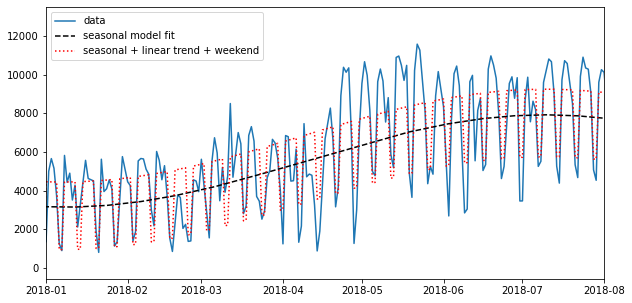

In [169]:
plt.figure(figsize=[10,5])
plt.style.use("fast")
plt.plot(y, label='data')
plt.plot(y_seasonal, '--k', label='seasonal model fit')
plt.plot(y_mod2, ':r', label='seasonal + linear trend + weekend')
plt.xlim(pd.to_datetime(['2018-01', '2018-08']))
plt.legend()
plt.show()

In a zoomed in plot it is much clearer the effect of the weekend on bicycle traffic, before looking at the data I personally had the assumption that bicycle traffic would have been greater on the weekends but it assumes that this is not the case. A Weekday/Weekend relationship strongly suggests that a large portion of the cyclists are commuters.

## 2020 prediction vs reality

We now have a model for bicycle traffic behavior in Seattle, fitted to data from 2012 to 2019. We can use this model to predict bicycle traffic into the future, to 2020, 2021, 2022, etc, or also back into the past if we wanted. The underlying assumption in such a prediction would be that the training period 2012-2019 is representative of other periods. So the prediction we get from the model can be interpreted as a prediction under "business-as-usual" conditions. 

We now know that 2020 was not a business-as-usual year by any stretch of the imagination. The world was largely on lockdown due to the Covid-19 pandemic which surely had an effect on bicycle traffic. In addition, Seattle saw a couple of month of civil unrest and riots in the summer of 2020, which surely also affected commuter behavior.

To quantify the effect of the 2020 covid lockdown and social unrest on Seattle bicycle traffic, we use the model fitted to the pre-2020 data and compare its 2020 prediction to the actually observed 2020 data. The mismatch between prediction and observation will tell us how much bicycle traffic differed in 2020 compared to "normal" times.

To keep things simple, we only use the seasonal. The pre-2020 model is used to express our expectation for 2020, and the discrepancy between expected and actual data in 2020 will be taken as an indicator for the effect of the unusual circumstances of 2020.

In [98]:
# refit model to seasonal and trend design matrix (pre-2020 data)
lm_seasonal = lm.fit(X_seasonal, y)

# construct design matrix that includes 2020 data
n_all = len(bike_daily)
np.arange(n_all)

array([   0,    1,    2, ..., 2887, 2888, 2889])

In [101]:
# constructing x values for all the data
omega = 2 * np.pi / 365.25
X_all = np.stack([np.sin(omega * t_all), np.cos(omega * t_all) ], axis=1) # seasonal + trend

# predict for the entire period, using the model trained on pre-2020 data
y_all = pd.Series(data=lm_seasonal.predict(X_all), index=bike_daily.index)

<Figure size 720x288 with 0 Axes>

(737211.0, 737699.0)

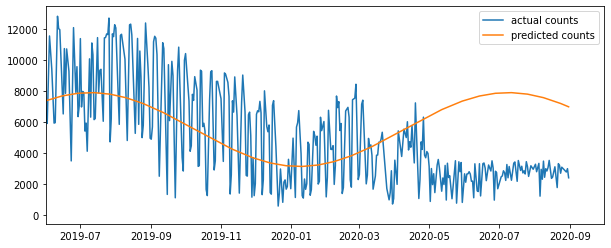

In [102]:
plt.figure(figsize=[10,4])v
plt.plot(bike_daily['total_bikes'], '-', label='actual counts')
plt.plot(y_all, '-', label='predicted counts')
plt.xlim(pd.to_datetime(['2019-06','2020-10']))
plt.legend()
plt.show()


The actual bicycle data for the 2020 data is far below the predicted model based on just the seasonal componenet, not including any of the longterm or weekend indicator function factors. We can visualise this by taking the difference between the 2 functions

<Figure size 720x288 with 0 Axes>

(737211.0, 737699.0)

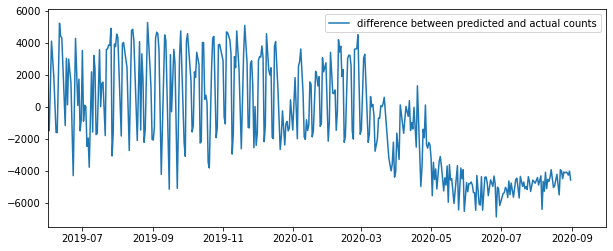

In [103]:
plt.figure(figsize=[10,4])
plt.plot(bike_daily['total_bikes'] - y_all, '-', label='difference between predicted and actual counts')
plt.xlim(pd.to_datetime(['2019-06','2020-10']))
plt.legend()
plt.show()


The difference between expected and actual bicycle traffic remains centered around 0 until about March, and starts going down significantly after that. The average difference after March 2020 goes down to around -6000, meaning that **about 6000 fewer people** crossed Fremont bridge by bike every day during that time.

## Exploring effects of the weather

Wether I go out for a run or not, whether i walk to work or catch the bus usually depends on the weather. There is weather data available at a local weather station near the bridge, at the nearby airport

The weather data has a number of columns containing weather information for Seattle airport, including minimum temperature, maximum temperature, and precipitation amount.

In [108]:
weather = pd.read_csv('data/SeattleWeather.csv', index_col='DATE', parse_dates=False)
weather.index = pd.to_datetime(weather.index, format="%Y-%m-%d")
weather
weather.isna().sum()

,STATION,NAME,AWND,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",16.33,0.00,NaN,66,46
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",14.54,0.00,NaN,66,47
2012-10-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",12.75,0.00,NaN,71,48
2012-10-06,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",11.41,0.00,NaN,75,46
2012-10-07,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2.91,0.00,NaN,75,46
...,...,...,...,...,...,...,...
2020-08-27,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.82,0.00,67.0,81,55
2020-08-28,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",7.38,0.00,68.0,78,58
2020-08-29,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.59,0.00,66.0,70,55


STATION      0
NAME         0
AWND         1
PRCP         0
TAVG       187
TMAX         0
TMIN         0
dtype: int64

There are alot of NaN values in Tavg.


To make the weather data useable as features for our analysis we make a couple of changes:

+ We rename the index column from DATE to date to make it consistent with the bike_daily DataFrame
+ The average daily temperature has many missing values, but minimum and maximum temperature columns appear to be complete. So we create a new column temperature    which is the midpoint between minimum and maximum temperature, as a proxy of the average temperature for that day.
+ We convert temperature from Fahrenheit to Celsius
+ We convert precipitation amounts from inches to mm
+ We only keep the date, precipitation, and temperature column

In [109]:
weather.index.name = 'date'
weather['temperature'] = weather['TMIN'] + 0.5 * (weather['TMAX'] - weather['TMIN'])
weather['temperature'] = (weather['temperature'] - 32) * 5/9
weather['precip'] = weather['PRCP'] * 25.4
weather = weather.loc[:, ['temperature', 'precip']]

weather

,temperature,precip
date,,
2012-10-03,13.333333,0.000
2012-10-04,13.611111,0.000
2012-10-05,15.277778,0.000
2012-10-06,15.833333,0.000
2012-10-07,15.833333,0.000
...,...,...
2020-08-27,20.000000,0.000
2020-08-28,20.000000,0.000
2020-08-29,16.944444,0.000


In [113]:
bike_weather = pd.concat([bike_daily_norm, weather], axis=1) ## we are still using the pre 2020 data here
bike_weather = bike_weather[bike_weather.index.year <= 2019]
bike_weather

## Always good to check data quality
bike_weather.isnull().agg([np.sum])

,total_bikes,east_bikes,west_bikes,day_of_week,is_weekend,temperature,precip
2012-10-03,7042.0,3520.0,3522.0,2.0,0.0,13.333333,0.000
2012-10-04,6950.0,3416.0,3534.0,3.0,0.0,13.611111,0.000
2012-10-05,6296.0,3116.0,3180.0,4.0,0.0,15.277778,0.000
2012-10-06,4012.0,2160.0,1852.0,5.0,1.0,15.833333,0.000
2012-10-07,4284.0,2382.0,1902.0,6.0,1.0,15.833333,0.000
...,...,...,...,...,...,...,...
2019-12-27,2276.0,796.0,1480.0,4.0,0.0,5.000000,0.254
2019-12-28,1676.0,764.0,912.0,5.0,1.0,6.666667,0.000
2019-12-29,1846.0,816.0,1030.0,6.0,1.0,7.500000,0.254
2019-12-30,3606.0,1190.0,2416.0,0.0,0.0,7.500000,1.016


,total_bikes,east_bikes,west_bikes,day_of_week,is_weekend,temperature,precip
sum,0,0,0,0,0,0,0


## Exploring weather data

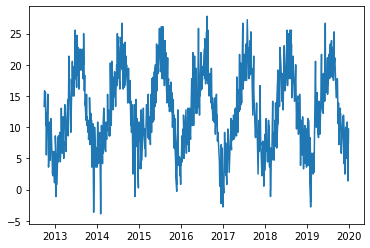

In [114]:
plt.plot(bike_weather['temperature'], '-')
plt.show()

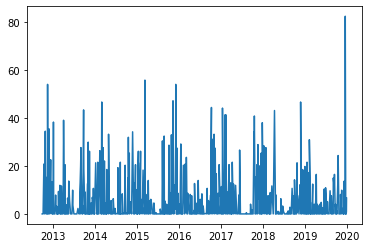

In [115]:
plt.plot(bike_weather['precip'], '-')
plt.show()

**Observations**
+ there is also a seasonal pattern in temperature and precipitation.

**New Questions**
+ how does predicted bike traffic depend on   
  - daily temperature values
  - daily precipitation values

## Effect of Weather

To assess the effect of rainy days, let's add an indicator variable of light rain 𝐼(𝑝𝑟𝑒𝑐𝑖𝑝𝑡≥1) that is zero on days where precipitation is less than 1mm (1 otherwise), and heavy rain 𝐼(𝑝𝑟𝑒𝑐𝑖𝑝𝑡≥10) that is zero on days where precipitation is less than 10mm (1 otherwise).

We will also add in the temperatue as a linear variable

For this investigation we will not consider weekend and long term trend. We will add these in after. The model being fitted is. 

$$y_t = \beta_0 + \beta_1 \sin(\omega t) + \beta_2 \cos(\omega t) + \beta_3 T(^oC) + \beta_4 I(r_1 \ge 1) + \beta_5 I(r_{10} \ge 10) + \epsilon_t$$



In [130]:
## Again adding in our indicator variables
bike_weather["rain_1"] = 0
bike_weather["rain_10"] = 0
## The day of the week with Monday=0, Sunday=6.

## monday 0 to friday 4
bike_weather.loc[ (bike_weather["precip"] > 1 ) , "rain_1"] = 1
## sat = 5 and sun = 6
bike_weather.loc[ (bike_weather["precip"] > 10 ), "rain_10"] = 1

## Defining the data
y = bike_weather['total_bikes']

In [131]:
bike_weather.head(20)
# The output is as we expect it to be,

,total_bikes,east_bikes,west_bikes,day_of_week,is_weekend,temperature,precip,rain_1,rain_10
2012-10-03,7042.0,3520.0,3522.0,2.0,0.0,13.333333,0.000,0,0
2012-10-04,6950.0,3416.0,3534.0,3.0,0.0,13.611111,0.000,0,0
2012-10-05,6296.0,3116.0,3180.0,4.0,0.0,15.277778,0.000,0,0
2012-10-06,4012.0,2160.0,1852.0,5.0,1.0,15.833333,0.000,0,0
2012-10-07,4284.0,2382.0,1902.0,6.0,1.0,15.833333,0.000,0,0
2012-10-08,7074.0,3658.0,3416.0,0.0,0.0,14.444444,0.000,0,0
2012-10-09,7002.0,3518.0,3484.0,1.0,0.0,12.500000,0.000,0,0
2012-10-10,6470.0,3296.0,3174.0,2.0,0.0,10.277778,0.000,0,0
2012-10-11,6094.0,3158.0,2936.0,3.0,0.0,10.555556,0.000,0,0
2012-10-12,4022.0,2044.0,1978.0,4.0,0.0,11.388889,2.032,1,0


In [153]:
## extracting the rain indicators
temp = bike_weather["temperature"]
temp = temp.to_numpy()

rain1 = bike_weather["rain_1"]
rain1 = rain1.to_numpy()

rain10 = bike_weather["rain_10"]
rain10 = rain10.to_numpy()


# defining our linear model matrix
X_mod3 = np.hstack([np.sin(omega * t).reshape(n, 1), np.cos(omega * t).reshape(n, 1), temp.reshape(n, 1),
                    rain1.reshape(n, 1), rain10.reshape(n, 1) ])

In [154]:
lm_mod3 = lm.fit(X_mod3, y)
y_mod3 = pd.Series(data=lm_mod3.predict(X_mod3), index=y.index)
lm_mod3.coef_

array([ -777.64678738,  -161.34504711,   171.04871799, -1194.60541927,
        -879.95744422])

The effect of including a wetness indicator is quite dramatic, as indicated by the large coefficient of about -1200 for light rain with -880 for heavy rain. The effect of rain is that, on average, about 1200 fewer people cycle on light rain days than on dry days and that on average 2080 fewer people cycle on heavy rain days. Since winters in Seattle are wetter than summers, there is a strong correlation between the seasonal predictors and the wetness indicator. As a result, the seasonality coefficients $\beta_1$ and $\beta_2$ change by quite a bit after including the wetness indicator. 

The temperature coefficient of 171 suggest that on avarage for each $1^oC$ increase in temperature there are an extra 171 people cycling.

## Plotting the Weather Model

<Figure size 720x360 with 0 Axes>

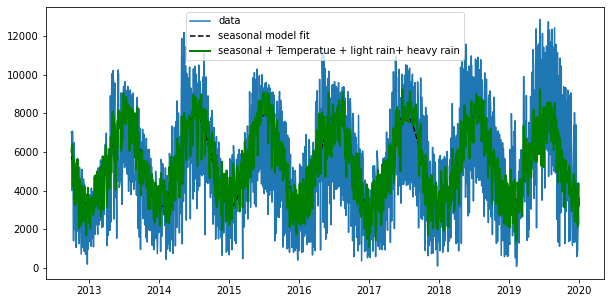

<Figure size 720x360 with 0 Axes>

(736695.0, 736907.0)

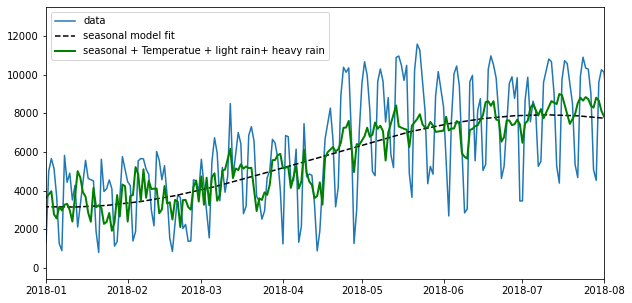

In [168]:
plt.figure(figsize=[10,5])
plt.style.use("fast")
plt.plot(y, label='data')
plt.plot(y_seasonal, '--k', label='seasonal model fit')
plt.plot(y_mod3, '-g', lw = 2, label='seasonal + Temperatue + light rain+ heavy rain')
plt.legend()
plt.show()

plt.figure(figsize=[10,5])
plt.style.use("fast")
plt.plot(y, label='data')
plt.plot(y_seasonal, '--k', label='seasonal model fit')
plt.plot(y_mod3, '-g', lw = 2, label='seasonal + Temperatue + light rain+ heavy rain')
plt.xlim(pd.to_datetime(['2018-01', '2018-08']))
plt.legend()
plt.show()

In [156]:
## Checking modelperformance
resid_var_3 = np.var(y_mod3 - y)
R2_3 = 1 - resid_var_3 / total_var
R2_3

R2_mod2
R2_seas

0.4674616802203363

0.7256200779317346

0.3778130484014063

The Weather model does a better job fitting to the data than just the seasonal model. However it performs worse than the weekend and long term trend model. lets see how combining the two models work.


## The final model

This will comprise of
+ Seasonal trend
+ Long term trend
+ Weekend
+ Temperature
+ Light Rain
+ Heavy rain

In [157]:
# defining our linear model matrix
X_mod4 = np.hstack([np.sin(omega * t).reshape(n, 1), np.cos(omega * t).reshape(n, 1), 
                    np.arange(n).reshape(n, 1), weekend.reshape(n, 1),
                    temp.reshape(n, 1),
                    rain1.reshape(n, 1), rain10.reshape(n, 1) ])

In [159]:
lm_mod4 = lm.fit(X_mod4, y)

y_mod4 = pd.Series(data=lm_mod4.predict(X_mod4), index=y.index)
lm_mod4.intercept_
lm_mod4.coef_

4368.453599744107

array([-8.24866137e+02, -1.68480662e+02,  4.48421036e-01, -3.45773307e+03,
        1.62673504e+02, -1.15430729e+03, -8.35789230e+02])

Values fo coefficients:

+ Seasonal trend: -825 (within the sin curve)
+ Long term trend: -168 (within the sine curve)
+ Weekend: -3457 people if weekend
+ Temperature: +162 people for each 1 deg increase in temperature
+ Light Rain: -1154 people fpr light rain
+ Heavy rain: - (1154 + 836 = ~2000) people for heavy rain. 

## Plot of the full model

<Figure size 864x576 with 0 Axes>

(736695.0, 736907.0)

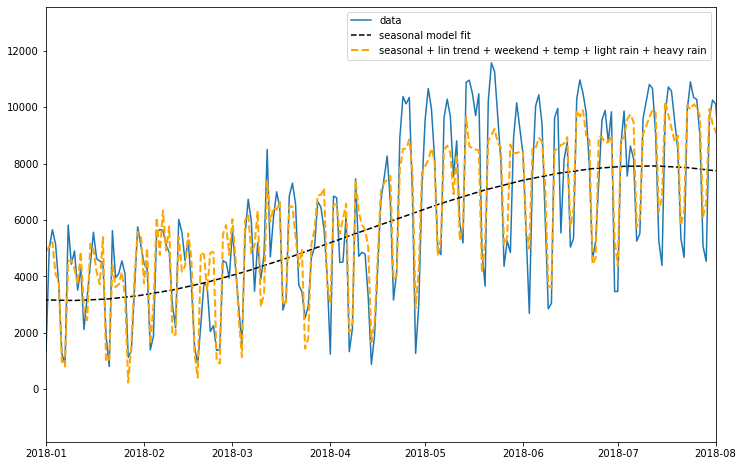

In [166]:
plt.figure(figsize=[12,8])
plt.style.use("fast")
plt.plot(y, label='data')
plt.plot(y_seasonal, '--k', label='seasonal model fit')
plt.plot(y_mod4, color='orange', linestyle='dashed', lw = 2,
         label='seasonal + lin trend + weekend + temp + light rain + heavy rain')
plt.xlim(pd.to_datetime(['2018-01', '2018-8']))
plt.legend()
plt.show()

In [170]:
## Checking modelperformance
resid_var_4 = np.var(y_mod4 - y)
R2_4 = 1 - resid_var_4 / total_var
R2_4

R2_3
R2_mod2
R2_seas

0.8079565411664934

0.4674616802203363

0.7256200779317346

0.3778130484014063

The combination of the 2 types of the model have increases the $R^2$ value from 0.378 with the seasonal model to a high value of 0.808 when all the factors are considered. 